# NeurIPS2018_SB3

This is a modification version based on the first notebook from [FinRL-tutorial](https://github.com/AI4Finance-Foundation/FinRL-Tutorials)

https://github.com/AI4Finance-Foundation/FinRL-Tutorials/blob/master/1-Introduction/Stock_NeurIPS2018_SB3.ipynb

## Part 1. Task Discription
DRL agent training for cryptocurrency trading. 

This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent selling, holding, and buying. When an action operates single crypto a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy 10 units of BTC" or "Sell 10 units of BTC" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s', i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively

**Market environment**: Cryptocurrencies from Binance

##  Part 2. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime, sqlite3, zipfile, os

%matplotlib inline
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from T3.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

/Users/HSY/miniconda3/envs/uoa-mdt/lib/python3.10/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


### Create Folders

In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

### Read Data

Read data from `binance-public-data`

In [3]:
TRAIN_START_DATE = '2017-08-17'
TRAIN_END_DATE = '2022-12-31'
TRADE_START_DATE = '2023-01-01'
TRADE_END_DATE = '2023-07-31'

In [4]:
# List of symbols to merge
symbols = ['BTCUSDT', 'ETHUSDT']

# List to store individual DataFrames
rawdfs = []

# Loop through each symbol
for symbol in symbols:
    directory = f'../mdt_utils/binance-public-data/python/data/spot/monthly/klines/{symbol}/1d/'
    
    # Loop through each zip file in the directory
    for file_name in os.listdir(directory):
        if file_name.endswith('.zip'):
            with zipfile.ZipFile(os.path.join(directory, file_name), 'r') as zip_ref:
                # only one CSV file in each zip archive
                csv_file = zip_ref.namelist()[0]
                with zip_ref.open(csv_file) as csv_fp:
                    # Read the CSV data into a DataFrame
                    temp_df = pd.read_csv(csv_fp, header=None)
                    temp_df.columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
                    temp_df['date'] = pd.to_datetime(temp_df['close_time'], unit='ms').dt.strftime('%Y-%m-%d')
                    temp_df['day'] = (pd.to_datetime(temp_df['date']) - pd.to_datetime(temp_df['date'].iloc[0])).dt.days
                    temp_df['tic'] = symbol
                    rawdfs.append(temp_df[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']])

# Concatenate all DataFrames into a single DataFrame
rawdf = pd.concat(rawdfs, ignore_index=True)

# Count the number of unique 'tic' values per date
tic_counts = rawdf.groupby('date')['tic'].nunique()

# Filter the DataFrame to keep only rows where all 'tic' values participate
df = rawdf[rawdf['date'].isin(tic_counts[tic_counts == len(rawdf['tic'].unique())].index)]
# Only wanted columns
df = df[['date', 'close', 'volume', 'tic', 'day']]

df.sort_values(['date','tic'],ignore_index=True).head()

,date,close,volume,tic,day
0,2017-08-17,4285.08,795.150377,BTCUSDT,0
1,2017-08-17,302.00,7030.710340,ETHUSDT,0
2,2017-08-18,4108.37,1199.888264,BTCUSDT,1
3,2017-08-18,293.96,9537.846460,ETHUSDT,1
4,2017-08-19,4139.98,381.309763,BTCUSDT,2


In [5]:
# Calculate the spread and total volume for each day
spread_df = df.groupby(['date']).agg({
    'close': lambda x: x.iloc[0] - x.iloc[1],  # BTCEUR - BTCGBP
    'volume': 'sum'  # Sum of volumes for both BTCEUR and BTCGBP
}).reset_index()
spread_df['tic']="Spread"

pivot_df = df.pivot(index='date', columns='tic', values='close').reset_index()
spread_df = pd.merge(spread_df, pivot_df, on='date')

# Calculate the 'day' column
spread_df['date'] = pd.to_datetime(spread_df['date'])
spread_df['day'] = (spread_df['date'] - spread_df['date'].iloc[0]).dt.days

spread_df['date'] = spread_df['date'].dt.strftime('%Y-%m-%d')

spread_df.tail(5)

,date,close,volume,tic,BTCUSDT,ETHUSDT,day
2170,2023-07-27,27361.50,186242.90216,Spread,29222.78,1861.28,2170
2171,2023-07-28,27439.95,162689.33097,Spread,29314.14,1874.19,2171
2172,2023-07-29,27472.44,83718.39534,Spread,29352.90,1880.46,2172
2173,2023-07-30,27419.30,174364.56461,Spread,29281.09,1861.79,2173
2174,2023-07-31,27376.11,190809.94304,Spread,29232.25,1856.14,2174


## Part 4. Preprocess Data

TODO: The default feature engineering is based on date. I need to rewrite into timestamp based method

The dafult [data split](https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/preprocessor/preprocessors.py) is not applicable here. Need to manually redo it.

In [6]:
INDICATORS = ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'close_30_sma', 'close_60_sma']

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=False,
                    user_defined_feature = False)

processed = fe.preprocess_data(spread_df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1496, 8)
Successfully added vix


In [7]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [8]:
processed_full.sort_values(['date'],ignore_index=True).tail(5)

,date,tic,close,volume,BTCUSDT,ETHUSDT,day,macd,boll_ub,boll_lb,rsi_30,close_30_sma,close_60_sma,vix
1491,2023-07-24,Spread,27326.50,316133.55161,29176.50,1850.00,2167.0,52.653296,29123.677505,27444.978495,50.069584,28407.238000,26870.975333,13.91
1492,2023-07-25,Spread,27371.25,173816.95780,29228.91,1857.66,2168.0,-5.265230,29141.878301,27304.457699,50.288501,28367.484333,26912.527333,13.86
1493,2023-07-26,Spread,27479.96,306022.16696,29351.96,1872.00,2169.0,-41.910967,29169.657244,27219.748756,50.830267,28336.515667,26953.453667,13.19
1494,2023-07-27,Spread,27361.50,186242.90216,29222.78,1861.28,2170.0,-79.594198,29172.175155,27106.001845,50.213388,28288.470333,26973.539333,14.41
1495,2023-07-28,Spread,27439.95,162689.33097,29314.14,1874.19,2171.0,-101.952920,29159.477721,27020.755279,50.623912,28261.489000,27000.141833,13.33


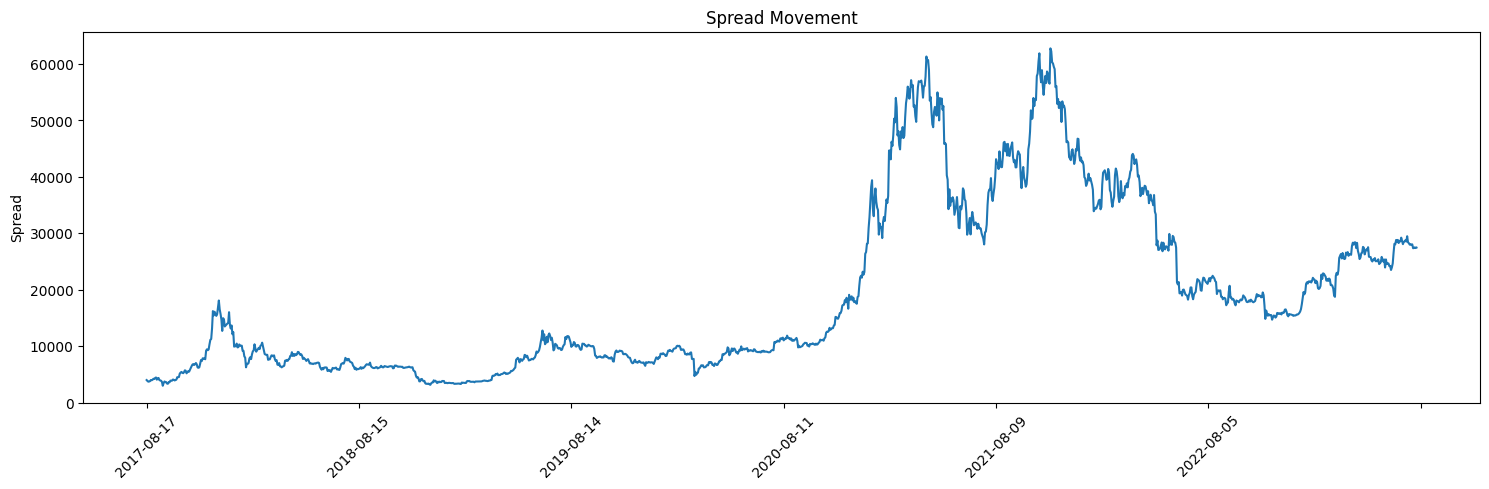

In [54]:
plt.plot(processed_full['date'], processed_full['close'])
plt.ylabel('Spread')
plt.title('Spread Movement')
plt.xticks(rotation=45)
plt.tight_layout()

max_ticks = 7  # Change this value as needed
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True, nbins=max_ticks))
# plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.show()

## Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing cryptocurrency price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

### Data Split
We split the data into training set and testing set as follows:

In [10]:
train = data_split(processed_full, TRAIN_START_DATE, TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE, TRADE_END_DATE)
train_length = len(train)
trade_length = len(trade)
print(f"Training Data length: {train_length}")
print(f"Trade Data Length: {trade_length}")
print(f"Indicators: {INDICATORS}")

Training Data length: 1353
Trade Data Length: 143
Indicators: ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'close_30_sma', 'close_60_sma']


Because we are trading with 2 assets as a pair, therefore we have only 1 pair_dimension

`1`: Represents the cash balance. There's one element in the state for the agent's cash.

`2 * stock_dimension`: Represents the stock prices and stock ownership. There are two elements for each stock: one for the stock price and one for the number of shares owned.

`len(INDICATORS) * stock_dimension`: Represents the technical indicators for each stock. Each indicator contributes one element per stock.

In [11]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(symbols + INDICATORS)*stock_dimension
print(f"Spread Dimension: {stock_dimension}, State Space: {state_space}")

Spread Dimension: 1, State Space: 11


In [12]:
# 0.1% was the default trading. However for pair trading, it should be doubled. 
buy_cost_list = sell_cost_list = [0.002] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 10,
    "initial_amount": 100000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": symbols + INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

In [13]:
# 100000, cash balance
# 3983.08, spread distance
# 0, number of "spread" holding
# 4285.08, the price of first symbol
# 302.0, the price of second symbol
# 0.0, technical indicator value
# 4137.28040156547, technical indicator value
# 3660.2095984345297, technical indicator value
# 0.0, technical indicator value
# 3983.08, technical indicator value
# 3983.08 technical indicator value

e_train_gym.state

[100000,
 3983.08,
 0,
 4285.08,
 302.0,
 0.0,
 4137.28040156547,
 3660.2095984345297,
 0.0,
 3983.08,
 3983.08]

### Environment for Training

In [14]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


## Part 6. Train DRL Agents
* The DRL algorithms are from Stable Baselines 3. Users are also encouraged to try ElegantRL and Ray RLlib.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

design their own DRL algorithms by adapting these DRL algorithms.

In [15]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = True
if_using_sac = True

### Agent 1: A2C

In [16]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [17]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000) if if_using_a2c else None

------------------------------------
| time/                 |          |
|    fps                | 1481     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | -0.00459 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 8.11     |
|    reward             | -5.2094  |
|    std                | 0.998    |
|    value_loss         | 60.1     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1724     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -1.42    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|

In [18]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [19]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cpu device
Logging to results/ddpg


In [20]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000) if if_using_ddpg else None

day: 1352, episode: 40
begin_total_asset: 100000.00
end_total_asset: 399214.67
total_reward: 299214.67
total_cost: 199.60
total_trades: 1352
Sharpe: 0.726
------------------------------------
| time/              |             |
|    episodes        | 4           |
|    fps             | 380         |
|    time_elapsed    | 14          |
|    total_timesteps | 5412        |
| train/             |             |
|    actor_loss      | 1.12e+03    |
|    critic_loss     | 8.18e+03    |
|    learning_rate   | 0.001       |
|    n_updates       | 4059        |
|    reward          | -0.06604568 |
------------------------------------
------------------------------------
| time/              |             |
|    episodes        | 8           |
|    fps             | 333         |
|    time_elapsed    | 32          |
|    total_timesteps | 10824       |
| train/             |             |
|    actor_loss      | 839         |
|    critic_loss     | 3.58e+03    |
|    learning_rate   | 0.001   

In [21]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [22]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to results/ppo


In [23]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 3236      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.3659677 |
----------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 2898         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0040192436 |
|    clip_fraction        | 0.0438       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.000495     |
|    learning_rate        | 0.00025      |
|    loss                 | 209          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00437    

In [24]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_ppo") if if_using_ppo else None

### Agent 4: TD3

In [25]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

if if_using_td3:
  # set up logger
  tmp_path = RESULTS_DIR + '/td3'
  new_logger_td3 = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_td3.set_logger(new_logger_td3)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cpu device
Logging to results/td3


In [26]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000) if if_using_td3 else None

----------------------------------
| time/              |           |
|    episodes        | 4         |
|    fps             | 396       |
|    time_elapsed    | 13        |
|    total_timesteps | 5412      |
| train/             |           |
|    actor_loss      | 1.83e+06  |
|    critic_loss     | 8.52e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 4059      |
|    reward          | -34.42119 |
----------------------------------
day: 1352, episode: 120
begin_total_asset: 100000.00
end_total_asset: -39404682.96
total_reward: -39504682.96
total_cost: -496094.86
total_trades: 1352
Sharpe: -0.869
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 345       |
|    time_elapsed    | 31        |
|    total_timesteps | 10824     |
| train/             |           |
|    actor_loss      | 2e+06     |
|    critic_loss     | 6.36e+10  |
|    learning_rate   | 0.001     |
|    n_updates       | 9471 

In [27]:
trained_td3.save(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None

### Agent 5: SAC

In [28]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
#     "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

if if_using_sac:
  # set up logger
  tmp_path = RESULTS_DIR + '/sac'
  new_logger_sac = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_sac.set_logger(new_logger_sac)

{'batch_size': 128, 'buffer_size': 100000, 'learning_rate': 0.0001, 'ent_coef': 'auto_0.1'}
Using cpu device
Logging to results/sac


In [29]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=70000) if if_using_sac else None

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 238      |
|    time_elapsed    | 22       |
|    total_timesteps | 5412     |
| train/             |          |
|    actor_loss      | 1.53e+04 |
|    critic_loss     | 3.59e+08 |
|    ent_coef        | 0.168    |
|    ent_coef_loss   | 16.7     |
|    learning_rate   | 0.0001   |
|    n_updates       | 5311     |
|    reward          | 0.0      |
---------------------------------
day: 1352, episode: 160
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 236      |
|    time_elapsed    | 45       |
|    total_timesteps | 10824    |
| train/             |          |
|    actor_loss      | 3.77e+03 |
|    critic_loss     | 4.77e+05 |
|    ent_coef        | 0.288    |
|    ent_coef_loss

In [30]:
trained_sac.save(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

### In-sample Performance
Assume that the initial capital is $1,000,000.

### Trading (Out-of-sample Performance)
We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

The Env
https://github.com/AI4Finance-Foundation/FinRL/blob/master/finrl/meta/env_stock_trading/env_stocktrading.py

In [31]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [32]:
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

trained_a2c = A2C.load("trained_models/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load("trained_models/agent_ddpg") if if_using_ddpg else None
trained_ppo = PPO.load("trained_models/agent_ppo") if if_using_ppo else None
trained_td3 = TD3.load("trained_models/agent_td3") if if_using_td3 else None
trained_sac = SAC.load("trained_models/agent_sac") if if_using_sac else None

In [33]:
trained_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [34]:
trained_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [35]:
trained_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [36]:
trained_model = trained_td3
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


In [37]:
trained_model = trained_sac
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_model, 
    environment = e_trade_gym)

hit end!


## Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [52]:
# df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
# df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
# df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
# df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
# df_result_td3 = df_account_value_td3.set_index(df_account_value_td3.columns[0])
# df_result_td3.rename(columns = {'account_value':'td3'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
# df_result_sac = df_account_value_sac.set_index(df_account_value_sac.columns[0])
# df_result_sac.rename(columns = {'account_value':'sac'}, inplace = True)

result = pd.DataFrame()
# result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_td3, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
# result = pd.merge(result, df_result_sac, how='outer', left_index=True, right_index=True)
print(result.head())
# result.columns = ['a2c', 'ddpg', 'td3', 'ppo', 'sac', 'mean var', 'dji']

# print("result: ", result)
result.to_csv(RESULTS_DIR + "/result.csv")

                 ppo
date                
2023-01-03  100000.0
2023-01-04  100000.0
2023-01-05  100000.0
2023-01-06  100000.0
2023-01-09  100000.0


<Figure size 1500x500 with 0 Axes>

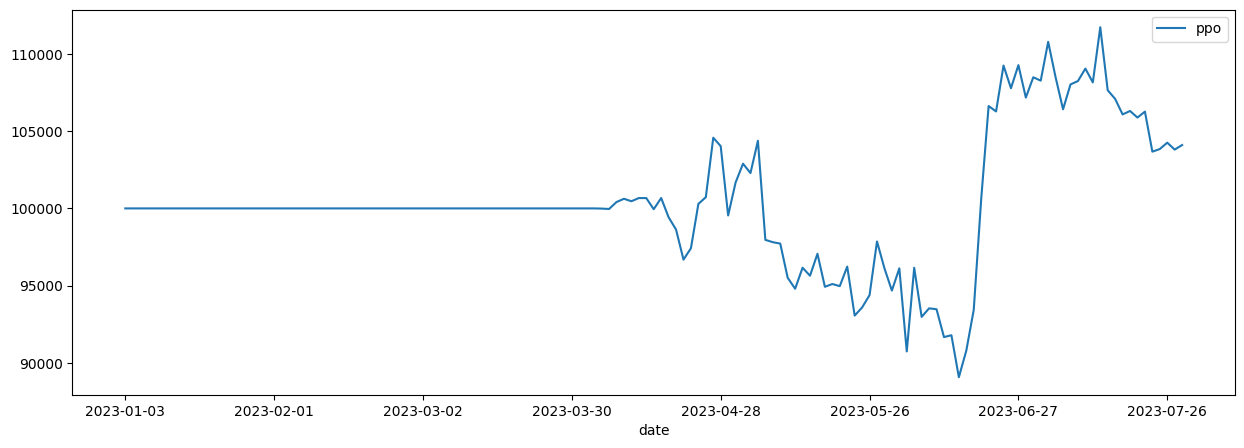

In [53]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();

<Axes: >

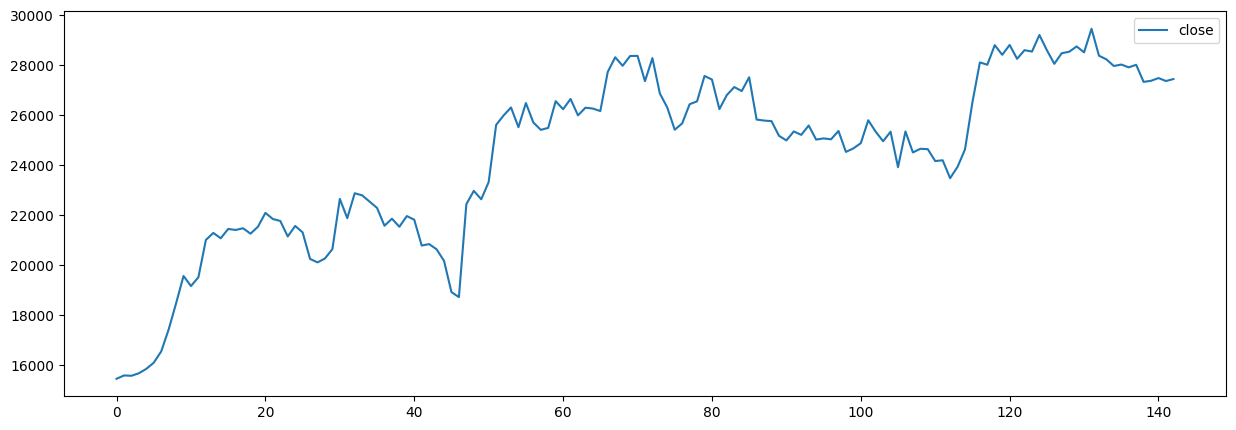

In [48]:
trade[['date', 'close']].plot()

<Axes: xlabel='date'>

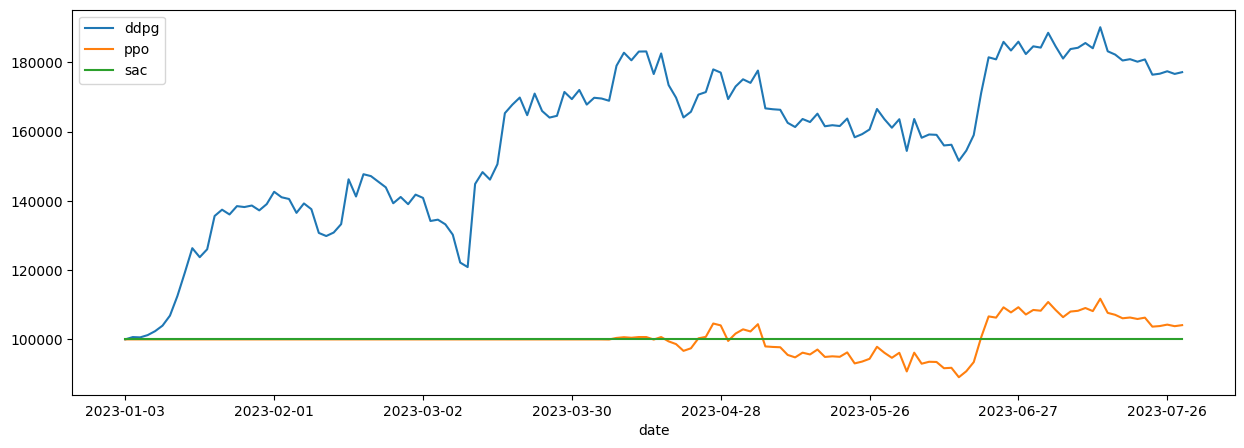

In [49]:
result.plot()